University of Stirling<br>
Computing Science and Mathematics<br>
#### CSCU9YE - Artificial Intelligence<p>   
## Assignment: Organising a Colour Palette 

Group 4: 2615649, 2622287, 2613922   

Task 2: Clustering-based Algorithm

Chosen Algorithm: K-Means

The following five blocks (imports, read_data(), plot_colors(), euclid(), evalutate()) are all found in other notebooks and are used in the multi-start hill climbing and greedy search. They are essentially there to set up the data, display the data and evaulate solutions. 

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


In [65]:
# Read in the color data file
# Input: string with file name
# Output: the number of colours (integer), and a list numpy arrays with all the colours
def read_data(fname):
    cols = np.loadtxt(fname, skiprows=4)  # The first 4 lines have text information, and are ignored
    ncols = len(cols)  # Total number of colours and list of colours
    return ncols, cols

In [66]:
# Display the colors as a strip of color bars
# Input: list of colors, order of colors, and height/ratio
def plot_colors(col_list, col_order, ratio=40):
    assert len(col_list) == len(col_order)
    img = np.zeros((ratio, len(col_list), 3))
    for i in range(0, len(col_list)):
        img[:, i, :] = col_list[col_order[i]]
    fig, axes = plt.subplots(1, figsize=(10, 6))  # figsize=(width,height) handles window dimensions
    axes.imshow(img, interpolation='nearest')
    axes.axis('off')
    plt.show()


In [67]:
def euclid(v, u):
    return np.linalg.norm(v - u)


In [68]:
# Evaluation function.  Measures the quality of a given solution (ordering of colours)
# The function computes the sum of the distances between all consecutive colours in the ordering
# Input: cols: list of colours
#        ordc: ordering of colours
# Output: real number with the sumf of pair-wise differences in the colour ordering
def evaluate(cols, ordc):
    adjacentColPairs = [[cols[ordc[i]], cols[ordc[i - 1]]] for i in range(1, len(ordc))]
    return sum([euclid(i[1], i[0]) for i in adjacentColPairs])


## Solution implementation

### K Means Clustering

For this we decided to use the k means clustering algorithm to sort the colour dataset as this is one of the best and most popular unsupervised machine learning algorithms. The K-Means clustering algorithm groups the colours into different clusters with similar colours being in the same cluster. This means that the individual colours in the clusters themselves may not be ordered but the clusters as a whole will be ordered. K-means clustering uses centroids, k number of different randomly-initiated points in the data, and assigns each data point to the nearest centroid. Once all the data points have been assigned, the centroid is moved to the average of all the points assigned to it. This process is repeated unitl no point changes its assigned centroid. <p>
    
This algorithm needs three inputs; the dataset, number of clusters, and number of iterations. 

The following function, k_means_clustering(), runs the k means clustering algorithm on the given dataset with a given number of clusters (k)

In [69]:
# K means clustering algorithm, 
# Input: file and k number of clusters
# Output: number of colours, original colour list, sorted colour list
def k_means_clustering(file, k):
    # Read the dataset file
    ncolors, col = read_data(file)

    # Create a new dataframe to hold the same info as txt file
    df = pd.DataFrame({'R': col[:, 0], 'G': col[:, 1], 'B': col[:, 2]})

    # Provide the number of clusters wanted
    number_of_clusters = k

    # Create the model, setting the number of clusters, fixing the random seed
    kmeans = KMeans(n_clusters=number_of_clusters)
    # Fit the model
    clusters = kmeans.fit_predict(df)

    # Add the cluster info to the original dataset as a new column
    df['Cluster'] = clusters  # New column called cluster

    # Sort the values by their cluster number
    df.sort_values(['Cluster'], inplace=True)

    # Remove the cluster identifier column to get the dataset in the same format as before (without four columns)
    df.drop(['Cluster'], axis=1, inplace=True)

    # Change from dataframe to numpy array
    final_sorted_colors = df.to_numpy()

    return ncolors, col, final_sorted_colors


## Best solution function
The following function, best_solution(), takes as input the dataset, number of clusters and number of iterations and will call the k_means method as many times as specified in iterations and return the solution with the best evaluation / smallest distance between colours.

In [54]:
# Best solution
# Input: file name, number of clusters, number of iterations
# Output: number of colours, list of colours of best solution
def best_solution(file, clusters, iterations):
    ncolors, orig_colors = read_data(file)

    # Print / display original colored list for visual comparison
    print("Original colour order")
    order1 = list(range(ncolors))
    if ncolors > 100: # If number of colours is more than 100 print plot at larger size
        plot_colors(orig_colors, order1, 80)
    else:
        plot_colors(orig_colors, order1, 20)
    
    orig_eval = evaluate(orig_colors, order1) # Evaluation of original dataset for comparison
    print("Evaluation for original dataset:", orig_eval)

    best_solution = orig_colors
    best_solution_distance = 10000

    order = list(range(ncolors))

    print("Generating kMeans solution for", file)
    for i in range(iterations): # For however many number of iterations there are
        ncolors, orig_colors, sorted_colors = k_means_clustering(file, clusters) # Call K-Means
        current_solution_distance = evaluate(sorted_colors, order) 

        # If the current solution is better than the best solution, i.e. the distance evaluation is smaller 
        # then set the current solution to be the best solution
        if current_solution_distance < best_solution_distance:
            best_solution = sorted_colors
            best_solution_distance = current_solution_distance

    return ncolors, best_solution, best_solution_distance


### Elbow Method

The following function, elbow_method(), determines the optimal value that k should be when using the k means clustering algorithm. The graph plotted by this function can be used a visual guide to determine the number of clusters.

In [55]:
# Elbow method
# To determine the optimal value of k in KMeans
# Input: file name
def elbow_method(file):
    print("Producing graphs for", file, "...")
    ncolors, col = read_data(file)

    # Distortion is calculated as the average of the squared distances from the cluster centers of
    # the respective clusters. Typically, the Euclidean distance metric is used.
    distortions = []
    # Inertias is the sum of squared distances of samples to their closest cluster center.
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(1, (int(ncolors/2)))

    # Create a new dataframe to hold the same info as txt file
    df = pd.DataFrame({'R': col[:, 0], 'G': col[:, 1], 'B': col[:, 2]})

    #  Iterate the values of k from 1 to half the number of colours in the file and calculate the
    #  values of distortions for each value of k and calculate the distortion and inertia for
    #  each value of k in the given range.
    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(df)
        kmeanModel.fit(df)

        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
        inertias.append(kmeanModel.inertia_)

        mapping1[k] = sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0]
        mapping2[k] = kmeanModel.inertia_

    # Plotting the different values of distortion
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()

    # Plotting the different values of inertias
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method using Inertia')
    plt.show()


 ### Plotting and displaying the data

Below we will assign the datasets being used (col100 and col500) to variables FILE1 and FILE2

In [56]:
# File names that hold the colour data
FILE1 = "col100.txt"
FILE2 = "col500.txt"

Now we can call the elbow method with each dataset.
This will produce two graphs for each file, one showing the different values of distortion and another showing the different values of inertias.

Producing graphs for col100.txt ...


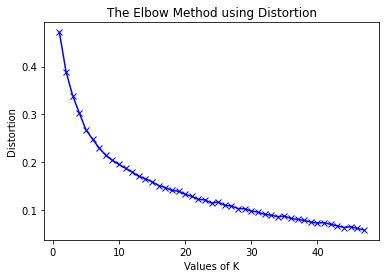

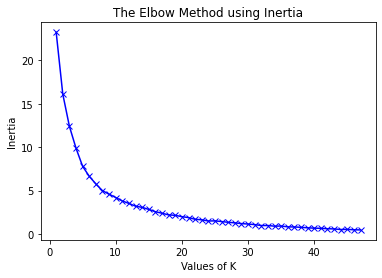

Producing graphs for col500.txt ...


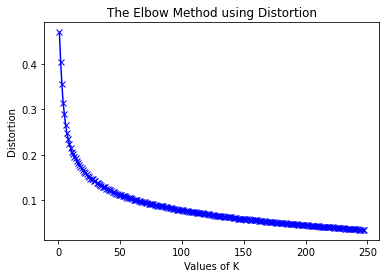

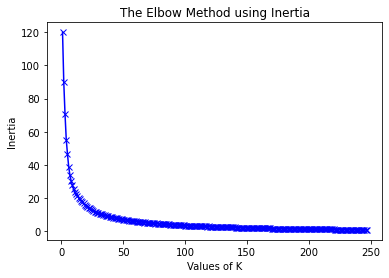

In [57]:
# Call elbow_method to run the 'elbow method' on each dataset to visually determine the optimal number of clusters
elbow_method(FILE1)
elbow_method(FILE2)

### Choosing k number of clusters

Looking at the graphs produced above we can evaluate the optimal number of clusters we should use on the datasets when applying the kMeans clustering algorithm. The idea is that we look at the graph and where it starts to flatten out is where we get our k number of clusters. For example col100 starts to flatten out at around 20 clusters as seen in the elbow method using intertia. 

### Running k means clustering algorithm

We used the results from the graphs above, using the elbow method, to set the number of clusters as 25 for col100 and 50 for col500, as done so below...

In [77]:
# Set the number of clusters and iterations for each dataset
NUMBER_CLUSTERS_FILE1 = 25
NUMBER_ITERATIONS_FILE1 = 200
NUMBER_CLUSTERS_FILE2 = 50
NUMBER_ITERATIONS_FILE2 = 300

Original colour order


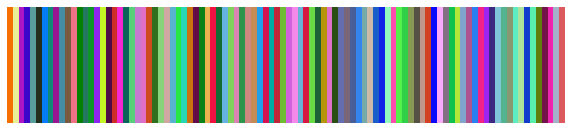

Evaluation for original dataset: 62.28133261068915
Generating kMeans solution for col100.txt


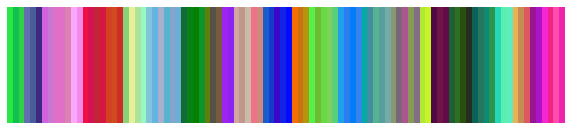

Final ordered list variables: 
File: col100.txt | Number of clusters: 25 | Number of iterations: 200 | Evaluation:  26.697813267166065


In [86]:
# Call best_iteration function with the variables above
ncols, best_sorted_colors1, best_distance1 = best_solution(FILE1, NUMBER_CLUSTERS_FILE1, NUMBER_ITERATIONS_FILE1)
# Plot the best_sorted_color list as a visual
order1 = list(range(ncols))
plot_colors(best_sorted_colors1, order1, 20)

cl_100_colours = best_sorted_colors1

# Print to terminal the variables used for the current solution
print("Final ordered list variables: ")
print(*['File:', FILE1, '| Number of clusters:', NUMBER_CLUSTERS_FILE1, '| Number of iterations:', NUMBER_ITERATIONS_FILE1, '| Evaluation: ', best_distance1])


Original colour order


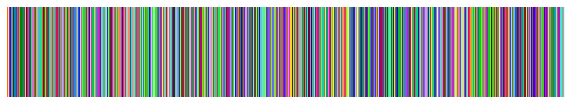

Evaluation for original dataset: 325.1667419062415
Generating kMeans solution for col500.txt


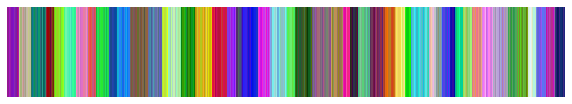

Final ordered list variables: 
File: col500.txt | Number of clusters: 50 | Number of iterations: 300 | Evaluation:  101.50068815108467


In [87]:
# Call best_iteration function with the variables above
ncols, best_sorted_colors2, best_distance2 = best_solution(FILE2, NUMBER_CLUSTERS_FILE2, NUMBER_ITERATIONS_FILE2)
# Plot the best_sorted_color list as a visual
order5 = list(range(ncols))
plot_colors(best_sorted_colors2, order5, 80)

cl_500_colours = best_sorted_colors2

# Print to terminal the variables used for the current solution
print("Final ordered list variables: ")

print(*['File:', FILE2, '| Number of clusters:', NUMBER_CLUSTERS_FILE2, '| Number of iterations:', NUMBER_ITERATIONS_FILE2, '| Evaluation: ', best_distance2])

## Evaluation of K-Means clustering

The datasets have already been given to us so no need to decide on those but the number of clusters and iterations was down to us to decide and to find the optimal point. <p>
        
To decide the number of clusters we used the elbow method, briefly described above, which takes the dataset and plots a graph showing where the 'eblow' is or where the results start to flatten out. This point determines the number of clusters that should be used. The number of iterations was a trial and error situation where I adjusted the value until I found the a decent figure to stick with. <p>
   

### Results

The result from col100 dataset gives an evaluation of around 27 which compared to the evaluation from the original dataset, 62, is a good improvement and you can clearly see from the colour plots that the colours have been sorted in a much better way. 
    
The same goes for the col500 dataset. The evaluation given for the original dataset was around 325, which when compared to the evaluation given after running the k means clustering algorithm, 101, gives a huge improvement. This is also backed up by the colour plots above where you can see a dramatic improvement on the ordering.

cl_best100 and cl_best500 are printed below...

#### As our solution doesnt use an ordering we used a function to find the ordering. 

In [88]:
def find_order(orig_col_array, col_sol_array):
    new_order = []
    
    for i in range(len(orig_col_array)):
        
        for j in range(len(orig_col_array)):
            if (col_sol_array[i] == orig_col_array[j]).all():
                    new_order.append(j)
                    break

    return new_order # re orderes colour list RGB values
ncolors100, cols100 = read_data(FILE1)
ncolors500, cols500 = read_data(FILE2)

cl_100 = find_order(cols100, cl_100_colours)
cl_500 = find_order(cols500, cl_500_colours)

print('cl_100:', cl_100)
print('\ncl_500:', cl_500)

cl_best100 = [29, 76, 68, 57, 59, 83, 48, 22, 55, 23, 39, 74, 49, 35, 44, 46, 51, 72, 24, 18, 26, 1, 88, 65, 84, 37, 94, 28, 78, 50, 36, 33, 12, 14, 91, 70,
              10, 82, 15, 27, 71, 62, 11, 41, 63, 89, 3, 64, 73, 0, 31, 54, 67, 47, 52, 38, 21, 43, 80, 6, 60, 45, 9, 85, 4, 61, 86, 58, 79, 69, 75, 77, 16,
              17, 92, 32, 53, 25, 56, 5, 20, 13, 7, 40, 30, 90, 87, 34, 42, 95, 8, 2, 19, 81, 66, 93] #26.6978

cl_best500 = [8, 333, 2, 196, 454, 211, 427, 447, 320, 172, 491, 154, 142, 27, 71, 181, 265, 293, 62, 445, 350, 13, 419, 7, 200, 485, 216, 393, 284, 215, 341, 
              210, 20, 161, 316, 388, 195, 460, 268, 156, 435, 264, 201, 421, 317, 429, 235, 424, 301, 122, 189, 340, 296, 118, 90, 261, 87, 386, 97, 375, 110, 
              166, 111, 450, 250, 402, 55, 23, 401, 39, 260, 22, 482, 257, 275, 248, 443, 300, 95, 348, 342, 125, 360, 29, 132, 337, 152, 378, 76, 188, 68, 63,
              274, 324, 380, 362, 179, 346, 383, 114, 354, 305, 403, 168, 60, 486, 43, 6, 80, 345, 325, 470, 105, 433, 10, 217, 187, 190, 183, 158, 467, 455, 
              70, 464, 329, 295, 313, 9, 59, 160, 369, 263, 57, 244, 121, 101, 240, 207, 77, 16, 175, 219, 290, 481, 169, 241, 283, 273, 143, 409, 65, 405, 88, 
              131, 229, 33, 484, 349, 165, 307, 291, 262, 159, 12, 14, 449, 314, 54, 473, 237, 412, 99, 434, 328, 397, 205, 170, 252, 310, 254, 173, 288, 35, 51,
              137, 332, 442, 209, 141, 358, 255, 18, 44, 245, 46, 410, 356, 15, 193, 469, 82, 247, 318, 233, 392, 231, 334, 439, 287, 3, 218, 331, 246, 308, 
              441, 468, 153, 73, 203, 315, 64, 89, 407, 425, 251, 480, 478, 19, 355, 144, 384, 438, 115, 199, 191, 78, 120, 488, 367, 130, 50, 37, 107, 145,
              390, 84, 140, 448, 279, 267, 321, 238, 228, 52, 67, 256, 25, 357, 36, 220, 53, 258, 462, 416, 177, 222, 56, 430, 171, 155, 389, 213, 353, 297, 
              204, 406, 489, 418, 58, 75, 306, 79, 139, 133, 436, 249, 457, 164, 312, 440, 69, 42, 185, 234, 400, 368, 474, 282, 395, 93, 286, 66, 411, 81, 
              103, 5, 343, 102, 338, 148, 453, 17, 335, 178, 149, 493, 21, 135, 85, 339, 379, 4, 259, 479, 206, 92, 32, 242, 239, 336, 147, 167, 471, 351, 444,
              376, 363, 423, 0, 243, 98, 24, 72, 294, 31, 34, 138, 404, 399, 302, 437, 377, 344, 1, 129, 428, 420, 322, 174, 422, 146, 408, 150, 225, 280, 184,
              492, 451, 198, 28, 459, 475, 227, 223, 30, 309, 106, 461, 330, 128, 163, 186, 417, 86, 61, 483, 373, 136, 134, 452, 109, 327, 266, 230, 126, 347,
              477, 224, 45, 352, 281, 194, 413, 364, 272, 415, 182, 113, 289, 38, 112, 26, 221, 446, 108, 104, 298, 100, 11, 299, 41, 162, 472, 285, 49, 74, 48,
              463, 372, 151, 387, 180, 94, 465, 214, 212, 385, 381, 226, 176, 271, 366, 157, 269, 494, 487, 431, 458, 96, 361, 40, 123, 277, 304, 476, 116, 432, 
              414, 119, 47, 124, 91, 278, 303, 311, 495, 382, 359, 398, 202, 326, 292, 391, 127, 323, 394, 371, 232, 236, 490, 396, 197, 117, 426, 370, 276, 192, 
              456, 253, 270, 208, 374, 319, 365, 83, 466] # 101.5006


cl_100: [29, 76, 68, 57, 59, 83, 48, 22, 55, 23, 39, 74, 49, 35, 44, 46, 51, 72, 24, 18, 26, 1, 88, 65, 84, 37, 94, 28, 78, 50, 36, 33, 12, 14, 91, 70, 10, 82, 15, 27, 71, 62, 11, 41, 63, 89, 3, 64, 73, 0, 31, 54, 67, 47, 52, 38, 21, 43, 80, 6, 60, 45, 9, 85, 4, 61, 86, 58, 79, 69, 75, 77, 16, 17, 92, 32, 53, 25, 56, 5, 20, 13, 7, 40, 30, 90, 87, 34, 42, 95, 8, 2, 19, 81, 66, 93]

cl_500: [8, 333, 2, 196, 454, 211, 427, 447, 320, 172, 491, 154, 142, 27, 71, 181, 265, 293, 62, 445, 350, 13, 419, 7, 200, 485, 216, 393, 284, 215, 341, 210, 20, 161, 316, 388, 195, 460, 268, 156, 435, 264, 201, 421, 317, 429, 235, 424, 301, 122, 189, 340, 296, 118, 90, 261, 87, 386, 97, 375, 110, 166, 111, 450, 250, 402, 55, 23, 401, 39, 260, 22, 482, 257, 275, 248, 443, 300, 95, 348, 342, 125, 360, 29, 132, 337, 152, 378, 76, 188, 68, 63, 274, 324, 380, 362, 179, 346, 383, 114, 354, 305, 403, 168, 60, 486, 43, 6, 80, 345, 325, 470, 105, 433, 10, 217, 187, 190, 183, 158, 467, 455, 70, 464, 329, 295, 313, 9,